In [128]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.feature_selection import mutual_info_classif
from sklearn.metrics import precision_score, recall_score, classification_report

from xgboost import XGBClassifier



In [ ]:
df = pd.read_csv('data.csv')

In [130]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6819 entries, 0 to 6818
Data columns (total 96 columns):
 #   Column                                                    Non-Null Count  Dtype  
---  ------                                                    --------------  -----  
 0   Bankrupt?                                                 6819 non-null   int64  
 1    ROA(C) before interest and depreciation before interest  6819 non-null   float64
 2    ROA(A) before interest and % after tax                   6819 non-null   float64
 3    ROA(B) before interest and depreciation after tax        6819 non-null   float64
 4    Operating Gross Margin                                   6819 non-null   float64
 5    Realized Sales Gross Margin                              6819 non-null   float64
 6    Operating Profit Rate                                    6819 non-null   float64
 7    Pre-tax net Interest Rate                                6819 non-null   float64
 8    After-tax net Int

In [131]:
print(df.describe())

         Bankrupt?   ROA(C) before interest and depreciation before interest  \
count  6819.000000                                        6819.000000          
mean      0.032263                                           0.505180          
std       0.176710                                           0.060686          
min       0.000000                                           0.000000          
25%       0.000000                                           0.476527          
50%       0.000000                                           0.502706          
75%       0.000000                                           0.535563          
max       1.000000                                           1.000000          

        ROA(A) before interest and % after tax  \
count                              6819.000000   
mean                                  0.558625   
std                                   0.065620   
min                                   0.000000   
25%                          

In [133]:





print("Null values count across the columns")
print(df.isnull().sum().tolist())

Null values count across the columns
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [134]:
def drop_correlated_features(X, threshold=0.85):
    corr = X.corr().abs()
    upper = corr.where(np.triu(np.ones(corr.shape), k=1).astype(bool))

    drop_cols = [
        column for column in upper.columns
        if any(upper[column] > threshold)
    ]
    return X.drop(columns=drop_cols), drop_cols


In [135]:
X, dropped_corr = drop_correlated_features(X, threshold=0.85)

print(f"Dropped {len(dropped_corr)} correlated features")

Dropped 2 correlated features


In [136]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    stratify=y,
    random_state=42
)

In [137]:
def winsorize_df(df, lower_q=0.01, upper_q=0.99):
    df_w = df.copy()
    for col in df_w.columns:
        lower = df_w[col].quantile(lower_q)
        upper = df_w[col].quantile(upper_q)
        df_w[col] = np.clip(df_w[col], lower, upper)
    return df_w


X_train = winsorize_df(X_train)
X_test  = winsorize_df(X_test)

In [138]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score
from sklearn.inspection import permutation_importance
from sklearn.metrics import make_scorer

neg = (y_train == 0).sum()
pos = (y_train == 1).sum()

xgb = XGBClassifier(
    n_estimators=300,
    max_depth=5,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    scale_pos_weight=neg / pos,
    eval_metric="logloss",
    random_state=42
)

xgb.fit(X_train, y_train)

,objective,'binary:logistic'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,0.8
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,'logloss'


In [139]:
gain_dict = xgb.get_booster().get_score(importance_type="gain")

imp_df = (
    pd.DataFrame.from_dict(gain_dict, orient="index", columns=["gain"])
    .reset_index()
    .rename(columns={"index": "feature"})
)

# Add zero-gain features
all_features = set(X_train.columns)
used_features = set(imp_df["feature"])

zero_gain = all_features - used_features
zero_df = pd.DataFrame({"feature": list(zero_gain), "gain": 0.0})

imp_df = pd.concat([imp_df, zero_df], ignore_index=True)
imp_df = imp_df.sort_values("gain", ascending=False)

In [140]:
# Drop features never used by the model
drop_zero_gain = imp_df.loc[imp_df["gain"] == 0, "feature"].tolist()

X_train = X_train.drop(columns=drop_zero_gain)
X_test  = X_test.drop(columns=drop_zero_gain)

In [141]:
# -------------------------------------------------
# 7. RETRAIN AFTER FEATURE PRUNING
# -------------------------------------------------
xgb.fit(X_train, y_train)

# -------------------------------------------------
# 8. PERMUTATION IMPORTANCE (RECALL-BASED)
# -------------------------------------------------
recall_scorer = make_scorer(recall_score)

perm = permutation_importance(
    xgb,
    X_test,
    y_test,
    scoring=recall_scorer,
    n_repeats=10,
    random_state=42
)

perm_df = pd.DataFrame({
    "feature": X_test.columns,
    "recall_impact": perm.importances_mean
}).sort_values("recall_impact", ascending=False)

In [142]:
# Drop features with ~zero recall impact
drop_perm = perm_df.loc[perm_df["recall_impact"] <= 0.0, "feature"].tolist()

X_train = X_train.drop(columns=drop_perm)
X_test  = X_test.drop(columns=drop_perm)

# -------------------------------------------------
# 9. FINAL TRAIN
# -------------------------------------------------
xgb.fit(X_train, y_train)

# -------------------------------------------------
# 10. FINAL EVALUATION (RECALL-FIRST)
# -------------------------------------------------
THRESHOLD = 0.15

y_prob = xgb.predict_proba(X_test)[:, 1]
y_pred = (y_prob >= THRESHOLD).astype(int)

print("FINAL RESULTS")
print("--------------")
print("Precision (bankruptcy):", precision_score(y_test, y_pred))
print("Recall    (bankruptcy):", recall_score(y_test, y_pred))

print("\nFinal feature count:", X_train.shape[1])
print("Dropped by correlation:", len(dropped_corr))
print("Dropped by zero-gain  :", len(drop_zero_gain))
print("Dropped by permutation:", len(drop_perm))

FINAL RESULTS
--------------
Precision (bankruptcy): 0.2916666666666667
Recall    (bankruptcy): 0.6363636363636364

Final feature count: 16
Dropped by correlation: 2
Dropped by zero-gain  : 1
Dropped by permutation: 1


In [143]:
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.metrics import make_scorer, recall_score

cv = StratifiedKFold(
    n_splits=5,
    shuffle=True,
    random_state=42
)

recall_scorer = make_scorer(recall_score)

param_grid = {
    "max_depth": [3, 4, 5],
    "learning_rate": [0.03, 0.05, 0.08],
    "min_child_weight": [1, 3, 5],
    "subsample": [0.7, 0.8, 0.9],
    "colsample_bytree": [0.7, 0.8, 0.9],
}

from xgboost import XGBClassifier

xgb_cv = XGBClassifier(
    n_estimators=300,
    scale_pos_weight=neg / pos,
    eval_metric="logloss",
    random_state=42
)

grid = GridSearchCV(
    estimator=xgb_cv,
    param_grid=param_grid,
    scoring=recall_scorer,
    cv=cv,
    n_jobs=-1,
    verbose=2
)

grid.fit(X_train, y_train)

print("Best CV Recall:", grid.best_score_)
print("Best Parameters:")
print(grid.best_params_)

best_xgb = grid.best_estimator_

best_xgb.fit(X_train, y_train)

from sklearn.metrics import precision_score, recall_score

THRESHOLD = 0.15

y_prob = best_xgb.predict_proba(X_test)[:, 1]
y_pred = (y_prob >= THRESHOLD).astype(int)

print("FINAL TUNED RESULTS")
print("-------------------")
print("Precision (bankruptcy):", precision_score(y_test, y_pred))
print("Recall    (bankruptcy):", recall_score(y_test, y_pred))



Fitting 5 folds for each of 243 candidates, totalling 1215 fits
Best CV Recall: 0.7614285714285713
Best Parameters:
{'colsample_bytree': 0.8, 'learning_rate': 0.03, 'max_depth': 3, 'min_child_weight': 5, 'subsample': 0.8}
FINAL TUNED RESULTS
-------------------
Precision (bankruptcy): 0.12714776632302405
Recall    (bankruptcy): 0.8409090909090909
(5455, 16)


In [145]:
import shap

explainer = shap.TreeExplainer(best_xgb)
shap_values = explainer.shap_values(X_train)


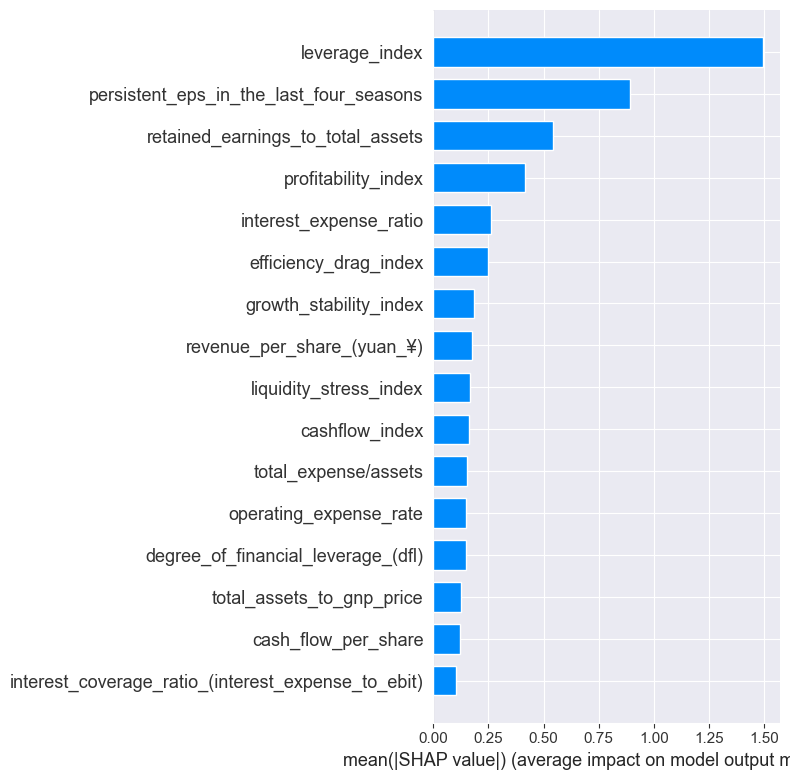

In [146]:
shap.summary_plot(
    shap_values,
    X_train,
    plot_type="bar"
)


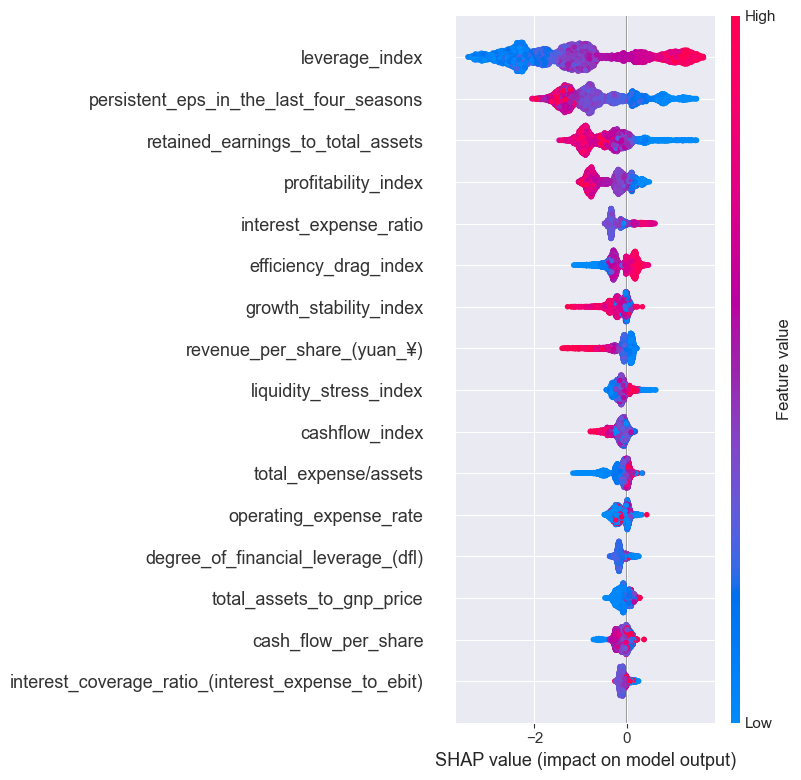

In [147]:
shap.summary_plot(
    shap_values,
    X_train
)


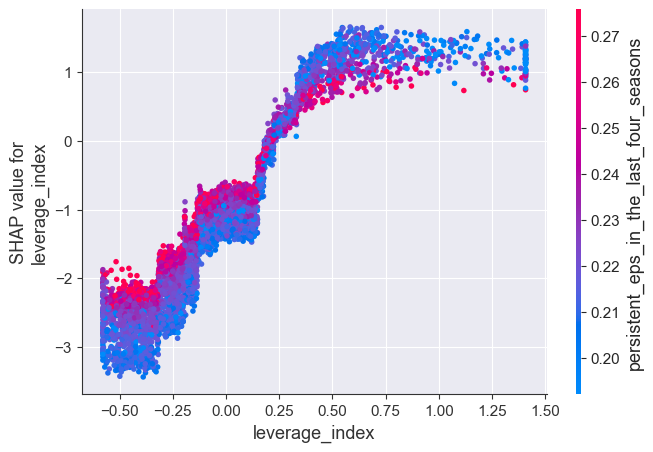

In [148]:
shap.dependence_plot(
    "leverage_index",
    shap_values,
    X_train
)
